In [1]:

from torchvision.utils import make_grid

from src.utils.dataset import dataset_to_dataloaders, show_class_name, get_class_example_image
from src.utils.visual import show_img, tensor_to_image, postprocess_image
from src.utils.training import fit, test_model
from src.models import download_model, HookedModel, load_model_weights_and_metrics
from src.deepdream import dream_process
from src.utils.config import RESNET18_FULL, RESNET18_TRANSFER, RESNET34_FULL, RESNET34_TRANSFER, RESNET50_FULL, RESNET50_TRANSFER, RESNET18_TEST, DEFAULT_OUTPUT_PATH
from src.utils.config import DREAM_CONFIG, BEETLE_DATASET, DEFAULT_TRAINING, DEFAULT_PLOTTING
from src.utils.config import get_new_config
from src.utils.custom_types import *

# Import configuration dictionaries
Things work a bit differently now. Below we import configuration dictionaries that define our model, dataset and training.

These dictionaries are defined inside `src/utils/config.py`.

In [2]:
dataset_config = BEETLE_DATASET
model_config = RESNET18_FULL
training_config = DEFAULT_TRAINING
plot_config = DEFAULT_PLOTTING

# Apply transforms and get dataloaders

dataset sizes: {'train': 11021, 'val': 1378, 'test': 1378}


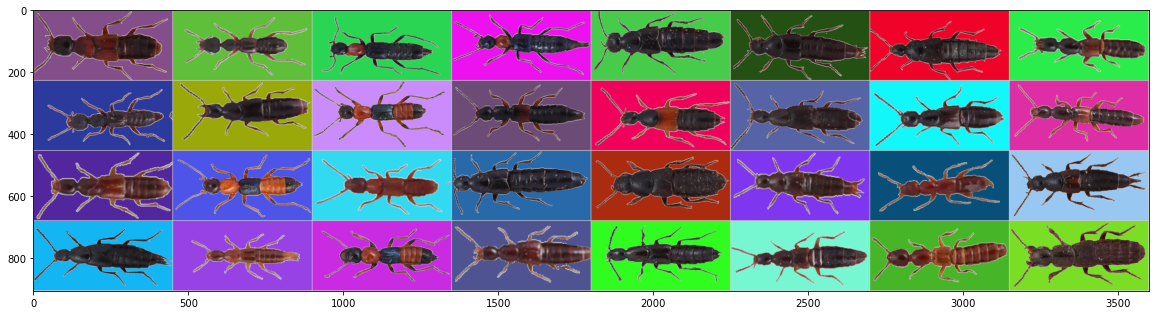

In [3]:
torch.cuda.empty_cache()

data_loaders, dataset_sizes = dataset_to_dataloaders(dataset_config)
iterable = iter(data_loaders['train'])
images, labels = next(iterable)
tensor_grid = make_grid(images, nrow=8)
image_grid = postprocess_image(tensor_to_image(tensor_grid))
show_img(image_grid, figsize=(20, 20))

# Define classification model

In [4]:
print('Loading {}'.format(model_config['model_architecture']))
model = download_model(model_config, dataset_config)

Loading resnet18


# Train and or load classification model

In [5]:
load = True

if load:
    metrics, model_config, dataset_config, training_config = load_model_weights_and_metrics(model, model_config)
    print(("test accuracy = %.2f %%" % training_config['train_info']['test_acc']))
else:
    metrics = fit(model, data_loaders, dataset_sizes,
                  model_config, training_config, dataset_config, plot_config, 
                  clear='notebook', plot=True, save_interval=1)
    acc = test_model(model, data_loaders['test'], training_config, str(model_config['device']))
_ = model.eval()

test accuracy = 89.11 %


# Expose layers

In [6]:
dreamnet = HookedModel(model)
_ = dreamnet.eval()
dreamnet.show_modules()

first layers,block 1,block 2,block 3,block 4,end layers
conv1,layer1,layer2,layer3,layer4,avgpool
bn1,layer1.0,layer2.0,layer3.0,layer4.0,fc
relu,layer1.0.conv1,layer2.0.conv1,layer3.0.conv1,layer4.0.conv1,
maxpool,layer1.0.bn1,layer2.0.bn1,layer3.0.bn1,layer4.0.bn1,
,layer1.0.relu,layer2.0.relu,layer3.0.relu,layer4.0.relu,
,layer1.0.conv2,layer2.0.conv2,layer3.0.conv2,layer4.0.conv2,
,layer1.0.bn2,layer2.0.bn2,layer3.0.bn2,layer4.0.bn2,
,layer1.1,layer2.0.downsample,layer3.0.downsample,layer4.0.downsample,
,layer1.1.conv1,layer2.0.downsample.0,layer3.0.downsample.0,layer4.0.downsample.0,
,layer1.1.bn1,layer2.0.downsample.1,layer3.0.downsample.1,layer4.0.downsample.1,


# Lets dream!

## Choose image

You can see what a specific class's name is with the function below.

In [7]:
show_class_name(0, dataset_config)

class 0: ./data/beetles/images/achenium_humile


This one takes a class label and returns an image instead.

Class path/name: ./data/beetles/images/achenium_humile


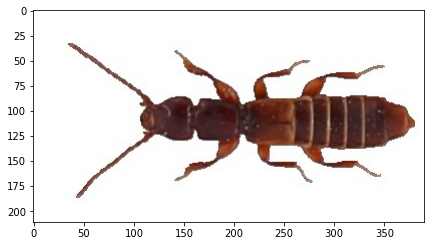

In [8]:
img = get_class_example_image(0, dataset_config)
show_img(img)

## Choose parameters and apply method

`out_info` is now a dictionary, and you can target modules in the model in a multitude of ways.

`{'fc': None}`      targets the entire `fc` layer

`{'fc': 1}`         targets class `1` in the `fc` layer

`{'fc': [0,1,2]}`   targets classes `0`,`1`,`2` in the `fc` layer


The same counts for 2d modules, such as `conv1`:

`{'conv1': (5,5)}`          targets `(5,5)` in `conv1`

`{'conv1': [(5,5), (2,2)]}`  targets `(5,5)` and `(2,2)` in `conv1`

In [9]:
import cv2 as cv
help(cv.VideoWriter)


Help on class VideoWriter in module cv2.cv2:

class VideoWriter(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  get(...)
 |      get(propId) -> retval
 |      .   @brief Returns the specified VideoWriter property
 |      .   
 |      .        @param propId Property identifier from cv::VideoWriterProperties (eg. cv::VIDEOWRITER_PROP_QUALITY)
 |      .        or one of @ref videoio_flags_others
 |      .   
 |      .        @return Value for the specified property. Value 0 is returned when querying a property that is
 |      .        not supported by the backend used by the VideoWriter instance.
 |  
 |  getBackendName(...)
 |      getBackendName() -> retval
 |      .   @brief Returns used backend API name
 |      .   
 |      .        @note Stream should be opened.
 |  
 |  isOpened(...)
 |      isOpened() -> retval


In [10]:
params = {
    'input_img_path': 'data/beetles/images/achenium_humile/_0189_0.jpg',
    'target_dict': {'fc': 4},
    'num_iters': 50,
    'levels': 3,
    'ratio':1.5,
    #'lr': 0.2,
    #'smooth_coef': 0,
    'noise': 'uniform',
    #'correlation' : 'gaussian',
    #'correlation_std' : 1,
    'target_shape': (200, 400),
    #'gauss_filter' : (7, 7, 5, 5),
    'show': True,
    'output_img_path': DEFAULT_OUTPUT_PATH + 'figures/dreamt_image.jpg',
    'video_path': DEFAULT_OUTPUT_PATH + 'videos/dreamt_image.mp4'
}
dream_config = get_new_config(params, DREAM_CONFIG)
output_images = dream_process(dreamnet, dream_config, model_config, dataset_config, training_config)


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x00\xc8\x08\x02\x00\x00\x00Iw \xb5\x…

FileNotFoundError: The gifsicle library was not found on your system.
On MacOS it is automatically installed using brew when you use the pip install command.
On other systems, like Linux systems and Windows, it prompts the instructions to be followed for completing the installation.
You can learn more on how to install gifsicle on the gifsicle and pygifsicle documentation.

In [ ]:
import skvideo
#help(skvideo.io.FFmpegWriter)


Help on class FFmpegWriter in module skvideo.io.ffmpeg:

class FFmpegWriter(skvideo.io.abstract.VideoWriterAbstract)
 |  FFmpegWriter(*args, **kwargs)
 |  
 |  Writes frames using FFmpeg
 |  
 |  Using FFmpeg as a backend, this class
 |  provides sane initializations for the default case.
 |  
 |  Method resolution order:
 |      FFmpegWriter
 |      skvideo.io.abstract.VideoWriterAbstract
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args, **kwargs)
 |      Prepares parameters
 |      
 |      Does not instantiate the an FFmpeg subprocess, but simply
 |      prepares the required parameters.
 |      
 |      Parameters
 |      ----------
 |      filename : string
 |          Video file path for writing
 |      
 |      inputdict : dict
 |          Input dictionary parameters, i.e. how to interpret the data coming from python.
 |      
 |      outputdict : dict
 |          Output dictionary parameters, i.e. how to encode the data
 |          when writi